In [75]:
import numpy as np
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import RegularPolygon
from scipy.spatial.distance import cdist
import itertools
import time
import matplotlib.cm as cm
from collections.abc import Collection

In [227]:
red = '#982649'
blue = '#60B2E5'
yellow = '#F6AE2D'
green = '#758E4F'
ocean = '#33658A'
coast = '#F9CB77'
unclaimed = '#FFFFFF'

In [283]:
class Hex():
    def __init__(self, color):
        self.color = color

    
    def __repr__(self):
        return str(self.color)
    
    def __eq__(self, other):
        return self.__dict__ == other.__dict__


class Grid():
    def __init__(self, size):
        self.grid = {}
        self.size = size
        self._directions = set(itertools.permutations((0, -1, 1)))
        self.grid = self.fresh_grid()

    def __str__(self):
        return str(self.grid)

    @property
    def coords(self):
        return np.array(list(self.grid.keys()))
    
    @property
    def colors(self):
        return [cell.color for cell in self.grid.values()]

    def __getitem__(self, idx):
        if idx[0] + idx[1] + idx[2] != 0:
            raise KeyError(f'{(idx[0], idx[1], idx[2])} is not a valid hex coordinate. x + y + z must equal zero.')
        return self.grid[idx[0], idx[1], idx[2]]

    def neighbors(self, idx):
        neighbors = [np.array(d) + np.array(idx) for d in self._directions
                        if tuple(np.array(d) + np.array(idx)) in self.grid]
        return np.array(neighbors)
    
    def random_colors(self):
        for k in self.grid:
            choices = [red, blue, yellow, green, unclaimed, ocean]
            results = np.random.choice(choices)
            self.grid[k].color = results
    
    def fresh_grid(self):
        grid = {}
        for x in range(-self.size, self.size + 1):
            for y in range(max(-self.size, -x - self.size), min(self.size, -x + self.size)+1):
                z = -x - y
                grid[(x, y, z)] = Hex(unclaimed)
        return grid

    def land_and_water(self, water_coef=3, beach_coef=3, land_coef=.5):
        
        for k in self.grid:
            self[k].color = np.random.choice([green, ocean],
                                                 p=[land_coef, 1-land_coef])
        def generate():
            new_grid = self.grid.copy()
            for k in self.grid:
                selfcolor = self.grid[k].color
                neighbor_colors = [self[n].color for n in self.neighbors(k)]
                colors, counts = np.unique(neighbor_colors, return_counts=True)
                coast_idx = np.argwhere(colors == coast)
                ocean_idx = np.argwhere(colors == ocean)
                if selfcolor == green:
                    if counts[ocean_idx] >= 1:
                        new_grid[k].color = coast
                elif selfcolor == coast:
                    if counts[ocean_idx] > beach_coef:
                        new_grid[k].color = ocean
                    if counts[ocean_idx] == 0:
                        new_grid[k].color = green
                elif selfcolor == ocean:
                    if counts[coast_idx] > water_coef:
                        new_grid[k].color = coast
            if self.grid == new_grid:
                self.grid = new_grid
            else:
                self.grid = new_grid
                generate()
        generate()
    
    def __eq__(self, other):
        return self.grid == other.grid
    

In [284]:
grid = Grid(50)
grid.land_and_water(water_coef=2, beach_coef=4)
draw_map(grid)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [265]:
def draw_map(grid):
    coords = grid.coords
    colors = grid.colors
    xcoord = coords[:, 0]
    ycoord = 2. * np.sin(np.radians(60)) * (coords[:, 1] - coords[:, 2]) /3.

    fig, ax = plt.subplots(1, figsize=(20, 20))
    ax.set_aspect('equal')
    patch_list = []
    for x, y, c in zip(xcoord, ycoord, colors):
        hexes = RegularPolygon((x, y), numVertices=6, radius=(2/3), orientation=np.radians(30), facecolor=c, edgecolor='k', linewidth=.25)
        patch_list.append(hexes)

    hexes = PatchCollection(patch_list, match_original=True)
    ax.add_collection(hexes)
    ax.axis('off')
    ax.scatter(xcoord, ycoord, alpha=0)
    plt.show()

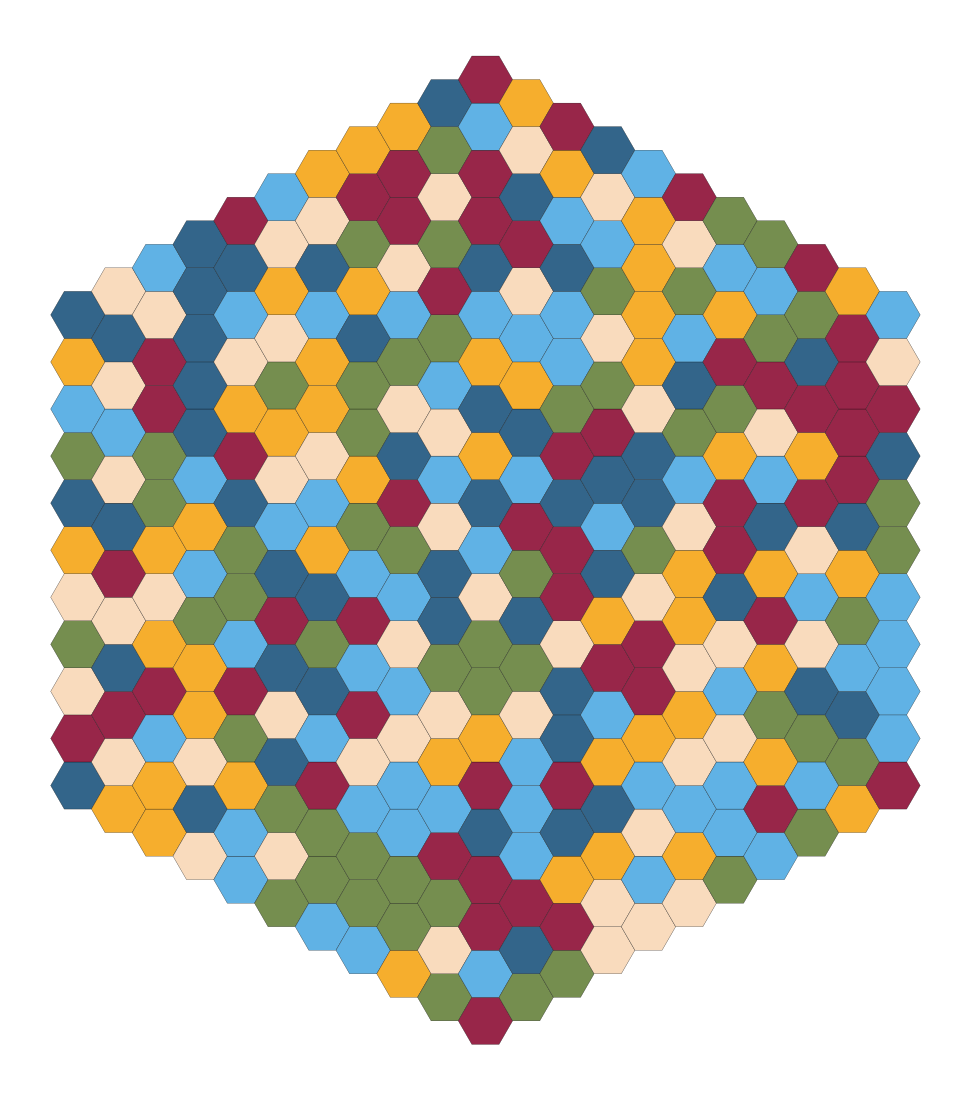

In [200]:
grid = Grid(10)
grid.random_colors()
draw_map(grid)